In [2]:
import numpy as np

# data generation

In [3]:
np.random.seed(24)
x = (np.random.uniform(size=1000)-0.5)*20
y_true = x*1.2-5
eps = np.random.normal(1, [np.sqrt(max(5,min(i,100))) for i in range(len(x))])
x = np.transpose(np.vstack((x, y_true+eps)))
y = (eps > 0)

In [4]:
r = np.random.uniform(size=len(x))
noise = np.where(r < (0.2/np.abs(eps)))
y[noise] = 1-y[noise]

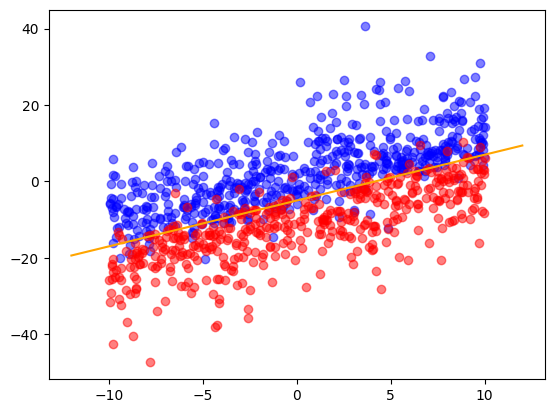

In [5]:
from matplotlib import pyplot as plt
plt.scatter(x[y==True,0],x[y==True,1], color='blue', alpha=0.5)
plt.scatter(x[y==False,0],x[y==False,1], color='red', alpha=0.5)
plt.plot(np.linspace(-12,12,100), np.linspace(-12,12,100)*1.2-5, color='orange')

# Implement logistic regression class

In [70]:
class LogisticRegression():
    eps_weight = 1e-3
    eps_loss = 1e-5
    max_iter = 10000
    
    def __init__(self, input_dim: int, learning_rate: float) -> None:
        self.input_dim = input_dim
        self.weights = np.random.normal(0,1,size=(input_dim+1,1))
        self.lr = learning_rate
    
    def compute_loss(self, weights, x, y):
        # x: (batch size, input_dim), weights: (input_dim+1, input_dim+1)
        y_prob = softmax(x @ weights[1:,:] + weights[0,:])
        # print(y_prob)
        return (-y.reshape((-1,1))*np.log(y_prob)-(1-y).reshape((-1,1))*np.log(1-y_prob)).mean(axis=0)
        
    def fit(self, x, y):    
        loss = []
        for n_iter in range(self.max_iter):
            w_delta = np.diag(np.ones(self.input_dim+1))*self.eps_weight
            w_l = self.weights - w_delta
            w_r = self.weights + w_delta
            w_grad = (self.compute_loss(w_r, x, y) - self.compute_loss(w_l, x, y))/(2*self.eps_weight)
            self.weights -= self.lr*w_grad.reshape(self.weights.shape)
            loss.append(self.compute_loss(self.weights, x, y)[0])
            if len(loss)>1 and np.abs(loss[-1] - loss[-2])<self.eps_loss:
                break
        #print(loss)
    def predict(self, x):
        y_prob = self.predict_proba(x)
        return (y_prob > 0.5)
        
    def predict_proba(self, x):
        return softmax(x @ self.weights[1:] + self.weights[0]).reshape(-1)

def softmax(x):
    return 1.0/(1+np.exp(-x))
    

In [71]:
lgr_clf = LogisticRegression(input_dim=2, learning_rate=1e-2)

In [72]:
test_idx = np.random.choice(len(x), int(0.3*len(x)), replace=False)
train_idx = np.array(list(set(range(len(x))) - set(test_idx)))

In [73]:
y = y.astype(float)

In [74]:
X_test, y_test = x[test_idx], y[test_idx]
X_train, y_train = x[train_idx], y[train_idx]

In [75]:
lgr_clf.compute_loss(lgr_clf.weights, X_train, y_train)

array([4.25204328])

In [89]:
def eval_metrics_auc(y_true, y_prob):
    idx = np.argsort(y_prob)
    n = len(idx)
    # tpr = tp/(tp+fn), fpr = fp/(fp+tn)
    tpr, fpr = [1.0], [1.0]
    tp, tn, fp, fn = y_true.sum(), 0, n-y_true.sum(), 0
    auc = 0
    
    for i in range(n):
        if y_true[idx[i]]==0:  # true negative
            fp -= 1
            tn += 1
            tpr.append(tp/(tp+fn))
            fpr.append(fp/(fp+tn))
            auc += tpr[-1] * (fpr[-2]-fpr[-1])
        else: # false negative
            fn += 1
            tp -= 1
            tpr.append(tp/(tp+fn))
            fpr.append(fp/(fp+tn))
            
    return auc, fpr, tpr

0.9712694512694529


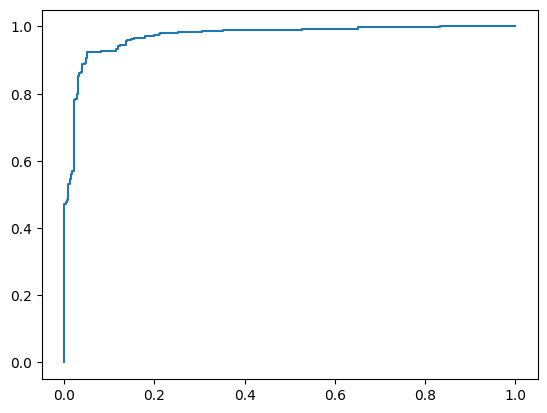

In [98]:
y_prob_train = lgr_clf.predict_proba(X_train)
auc, fpr, tpr = eval_metrics_auc(y_train, y_prob_train)
plt.plot(fpr, tpr)
print(auc)

0.9402262443438919


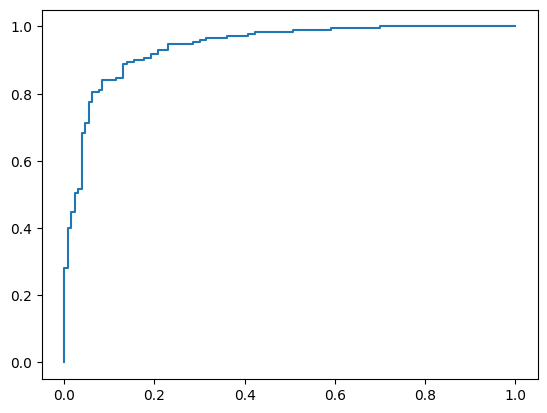

In [99]:
y_prob_test = lgr_clf.predict_proba(X_test)
auc, fpr, tpr = eval_metrics_auc(y_test, y_prob_test)
plt.plot(fpr, tpr)
print(auc)

In [60]:
a = np.array([2,3])

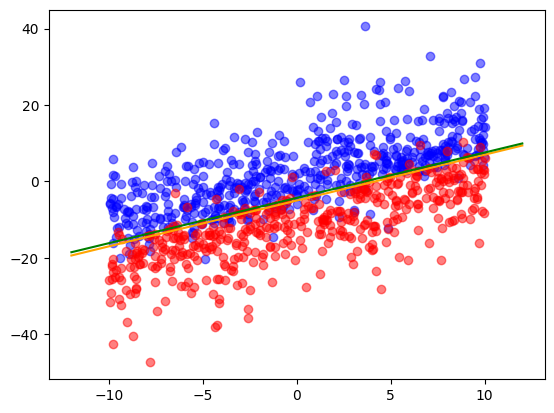

In [86]:
from matplotlib import pyplot as plt
plt.scatter(x[y==True,0],x[y==True,1], color='blue', alpha=0.5)
plt.scatter(x[y==False,0],x[y==False,1], color='red', alpha=0.5)
plt.plot(np.linspace(-12,12,100), np.linspace(-12,12,100)*1.2-5, color='orange')
plt.plot(np.linspace(-12,12,100), 
         -(lgr_clf.weights[0] + lgr_clf.weights[1] * np.linspace(-12,12,100))/lgr_clf.weights[2], 
         color='green')

# SVM

In [127]:
class SVM():
    eps_weights = 1e-3
    
    def __init__(self, input_dim: int, reg_lambda: float=1, learning_rate: float=1e-3, max_iter: int=1000, eps_loss: float=1e-3):
        self.input_dim = input_dim
        self.reg_lambda = reg_lambda
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.eps_loss = eps_loss
        self.weights = np.random.normal(0,1, size=(input_dim+1,1)) # index 0 is bias
        
    def compute_loss(self, weights, x, y):
        # x: (batch size, input_dim), y: (batch size), weights: (input_dim+1, 1) or (input_dim+1, n_weights)
        return (np.maximum(0, 1 - (x @ weights[1:] + weights[0]) * y.reshape((-1,1)))).sum(axis=0) + self.reg_lambda * (weights[1:] * weights[1:]).sum(axis=0)  # (n_weights)
        
    def fit(self, x, y):
        y[y==0] = -1
        dw = np.diag(np.ones(self.input_dim+1)) * self.eps_weights
        loss = []
        for i in range(self.max_iter):
            w_grad = (self.compute_loss(self.weights+dw, x, y) - self.compute_loss(self.weights-dw, x, y)) / (2*self.eps_weights)
            w_grad = w_grad.reshape((-1,1))
            self.weights -= self.learning_rate * w_grad
            loss.append(self.compute_loss(self.weights, x, y)[0])
            if len(loss)>2 and abs(loss[-1] - loss[-2]) < self.eps_loss:
                break
        
    def predict(self, x):
        return (x @ self.weights[1:] + self.weights[0] > 0).reshape(-1)
    

In [128]:
svm_clf = SVM(2)

In [129]:
svm_clf.fit(X_train, y_train)

In [132]:
(svm_clf.predict(X_test)==y_test).mean()

0.8433333333333334

In [133]:
# reorder alphabet so that any adjacent alphabet is not the same. output empty string if not possible
# Input: "aaabcc", Output: "abacac", 
# Input: "aaab", Output: ""

In [ ]:
def reorder(s: str) -> str:
    d = {}
    n = len(s)
    for c in s:
        if c in d:
            d[c] += 1
        else:
            d[c] = 1
    max_v = 0
    odd_letter = [""]
    for k,v in d.items():
        if v > (n+1)//2:
            return ""
        if v > max_v:
            odd_letter[0] = k
    